# Setting up

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib

%matplotlib inline
sns.set(style = "whitegrid")
pd.set_option('display.max_columns', 500)

In [ ]:
# %%time
# path = 'D://Coding//XTX Forecasting Challenge//data-training.csv'
# df = pd.read_csv(path)

In [112]:
%%time
path = 'D://Coding//XTX Forecasting Challenge//data-training.file'
df = pd.read_feather(path, use_threads=8)
df = df.astype('float32')

C:\Users\Tym\Anaconda3\envs\xtx\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Wall time: 6.98 s


# Exploratory Data Analysis

In [ ]:
# # Plot of [y] distribution
# fig, ax = plt.subplots(figsize=(15,8))
# sns.kdeplot(df.y, bw=0.01)

In [4]:
%%time
# Some feature engineering
df.fillna(0, inplace=True)
df['spread'] = df.askRate0 - df.bidRate0
df['midRate'] = (df.askRate0 + df.bidRate0) / 2
# df['expectedY'] = df.midRate.diff(87).shift(-87).clip(-5,5)

Wall time: 419 ms


In [5]:
# # Figuring out what [y] is
# # y(t) is midRate(t+87) - midRate(t), clipped to (-5.5)
# sum(df.y == df.expectedY)
# df.loc[df.y != df.expectedY]

# fig, ax = plt.subplots(figsize=(15,8))
# i = 500
# shift = 87
# # plt.plot(df.index[0:i], df.midRate[0:i].diff(shift).shift(-shift+14))
# plt.plot(df.index[-i:], df.midRate[-i:].diff(shift).shift(-shift))
# plt.plot(df.index[-i:], df.y[-i:])
# plt.legend(('midRate', 'y'))

# Feature engineering

### Basics

In [6]:
bidSizeList = ['bidSize' + str(i) for i in range(0,15)]
askSizeList = ['askSize' + str(i) for i in range(0,15)]
bidRateList = ['bidRate' + str(i) for i in range(0,15)]
askRateList = ['askRate' + str(i) for i in range(0,15)]

In [7]:
%%time
df['totalBidVol1'] = df.bidSize0 + df.bidSize1
for i in range(2,15):
    df['totalBidVol' + str(i)] = df['totalBidVol' + str(i-1)] + df['bidSize' + str(i)]

df['totalAskVol1'] = df.askSize0 + df.askSize1
for i in range(2,15):
    df['totalAskVol' + str(i)] = df['totalAskVol' + str(i-1)] + df['askSize' + str(i)]
    
for i in range(1,15):
    df['bidAskRatio' + str(i)] = df['totalBidVol' + str(i)] / df['totalAskVol' + str(i)]

df['totalAvailVol'] = df.totalBidVol14 + df.totalAskVol14

Wall time: 626 ms


In [8]:
%%time
df['vwaBid'] = np.einsum('ij,ji->i', df[bidRateList], df[bidSizeList].T) / df[bidSizeList].sum(axis=1)
df['vwaAsk'] = np.einsum('ij,ji->i', df[askRateList], df[askSizeList].T) / df[askSizeList].sum(axis=1)
df['vwaBidDMid'] = df.midRate - df.vwaBid
df['vwaAskDMid'] = df.vwaAsk - df.midRate
df['diff_vwaBidAskDMid'] = df.vwaAskDMid - df.vwaBidDMid

Wall time: 5.96 s


# Ideas from papers

In [9]:
%%time
# Volume Order Imbalance
# I still disagree with cancelled orders..
b1, a1 = (df.bidRate0 < df.bidRate0.shift(-1)), (df.askRate0 < df.askRate0.shift(-1))
b2, a2 = (df.bidRate0 == df.bidRate0.shift(-1)), (df.askRate0 == df.askRate0.shift(-1))
valsB, valsA = [0, (df.bidSize0 - df.bidSize0.shift(-1))], [0, (df.askSize0 - df.askSize0.shift(-1))]
defaultB, defaultA = df.bidSize0, df.askSize0

df['deltaVBid'] = np.select([b1,b2], valsB, default=defaultB)
df['deltaVAsk'] = np.select([a1,a2], valsA, default=defaultA)
df['VOI'] = df.deltaVBid - df.deltaVAsk

Wall time: 243 ms


In [10]:
%%time
# Order Imbalance Ratio
df['OIR'] = (df.bidSize0 - df.askSize0)/(df.bidSize0 + df.askSize0)

# when OIR is small, suggests that signal from VOI is weak

Wall time: 41 ms


# TA

In [11]:
%%time
overlapList = [talib.DEMA, talib.EMA, talib.HT_TRENDLINE, talib.KAMA, talib.MA,
               talib.SMA, talib.T3, talib.TEMA, talib.TRIMA, talib.WMA]
for func in overlapList:
    df[str(func.__name__)] = func(df.midRate)

Wall time: 1.22 s


In [12]:
%%time
momentumList = [talib.APO, talib.CMO, talib.MOM, talib.PPO, talib.ROC, talib.ROCR,
                talib.RSI, talib.TRIX]
for func in momentumList:
    df[str(func.__name__)] = func(df.midRate)

Wall time: 724 ms


In [13]:
%%time
# not true OBV
volumeIndicatorList = [talib.OBV]
for func in volumeIndicatorList:
    df[str(func.__name__)] = func(df.midRate, df.totalAvailVol)

Wall time: 105 ms


In [14]:
%%time
cycleIndicatorList = [talib.HT_DCPERIOD, talib.HT_DCPHASE, talib.HT_TRENDMODE]
for func in cycleIndicatorList:
    df[str(func.__name__)] = func(df.midRate)

Wall time: 5.15 s


In [15]:
%%time
statisticList = [talib.LINEARREG, talib.LINEARREG_SLOPE, talib.STDDEV, talib.TSF]
for func in statisticList:
    df[str(func.__name__)] = func(df.midRate)

Wall time: 566 ms


In [16]:
%%time
mathOpList = [talib.MAX, talib.MIN]
for func in mathOpList:
    df[str(func.__name__)] = func(df.midRate)

Wall time: 156 ms


In [17]:
df.fillna(0, inplace=True)

In [18]:
%time df.to_feather('intermediate.file')

Wall time: 6.22 s


In [124]:
%time df = pd.read_feather('intermediate.file')

Wall time: 13.5 s


In [125]:
# drop original features
df.drop(df.columns[:60], axis=1, inplace=True)

# Feature Selection

In [ ]:
# try PCA

# Cross-validation

In [19]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from rolling import RollingWindowSplit

In [157]:
%%time
# for regression
# X = df.drop('y', axis=1).values
X = df.drop('y', axis=1).iloc[:,indices[:50]].values
y = df.y.values

Wall time: 2.7 s


In [148]:
%%time
# for classification (one-vs-rest)
# X = df.drop('y', axis=1).values
X = df.drop('y', axis=1).iloc[:,indices[:50]].values
# trying with less features
# X = df.drop('y', axis=1).iloc[:,indices[:50]].values
y = (df.y.values*100).astype(int)

Wall time: 3.5 s


In [158]:
rlcv = RollingWindowSplit(n_splits=5, compatible=True)
for inc, (train_index, valid_index) in enumerate(rlcv.split(X), 1):
    x_train, x_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    print("TRAIN:", (train_index[0], train_index[-1]),
          "VALID:", (valid_index[0], valid_index[-1]),
          "SIZES:", (len(x_train), len(x_valid)))

TRAIN: (2, 428572) VALID: (428573, 857143) SIZES: (428571, 428571)
TRAIN: (428573, 857143) VALID: (857144, 1285714) SIZES: (428571, 428571)
TRAIN: (857144, 1285714) VALID: (1285715, 1714285) SIZES: (428571, 428571)
TRAIN: (1285715, 1714285) VALID: (1714286, 2142856) SIZES: (428571, 428571)
TRAIN: (1714286, 2142856) VALID: (2142857, 2571427) SIZES: (428571, 428571)


In [159]:
%%time
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestClassifier(n_jobs=-1).fit(x_train, y_train)
rf = RandomForestRegressor(n_jobs=-1).fit(x_train, y_train)

C:\Users\Tym\Anaconda3\envs\xtx\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 3min 11s


Feature ranking:
1. feature 71 (0.027240)
2. feature 73 (0.022178)
3. feature 55 (0.021845)
4. feature 72 (0.021807)
5. feature 65 (0.021400)
6. feature 70 (0.021236)
7. feature 54 (0.019967)
8. feature 61 (0.019112)
9. feature 48 (0.017944)
10. feature 47 (0.017574)
11. feature 49 (0.017048)
12. feature 57 (0.016597)
13. feature 74 (0.015908)
14. feature 62 (0.015399)
15. feature 44 (0.015322)
16. feature 45 (0.015223)
17. feature 46 (0.015022)
18. feature 56 (0.014858)
19. feature 63 (0.014550)
20. feature 59 (0.014423)
21. feature 58 (0.014258)
22. feature 0 (0.014204)
23. feature 42 (0.014005)
24. feature 41 (0.013888)
25. feature 43 (0.013873)
26. feature 29 (0.013247)
27. feature 40 (0.013133)
28. feature 39 (0.013009)
29. feature 38 (0.012710)
30. feature 28 (0.012641)
31. feature 26 (0.012641)
32. feature 35 (0.012520)
33. feature 36 (0.012496)
34. feature 37 (0.012465)
35. feature 30 (0.012428)
36. feature 27 (0.012393)
37. feature 14 (0.012375)
38. feature 34 (0.012330)
39. f

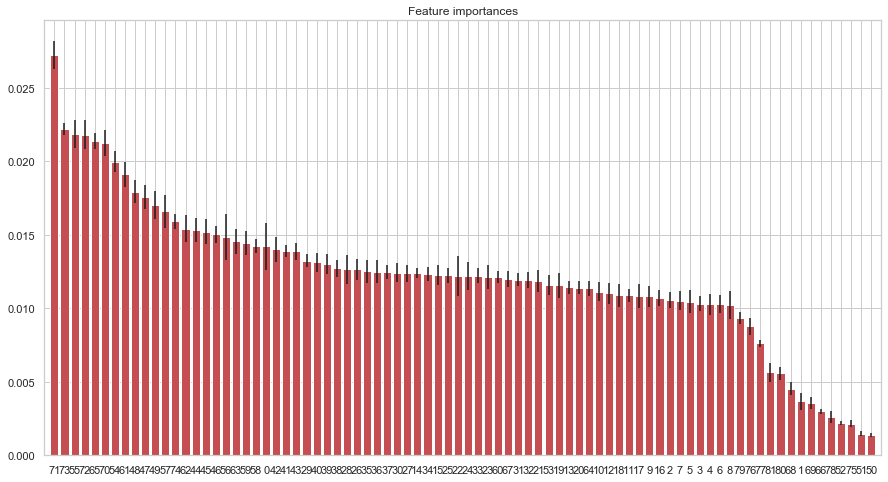

In [131]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [160]:
# in-sample
rf.score(x_train, y_train)

0.9876642772886836

In [161]:
# out-of-sample
rf.score(x_valid, y_valid)

-0.44688661961951515

In [89]:
# do some rounding of continuous values
def rounding(number):
    return np.round(number * 4, decimals=0) / 4
rpredictions = rounding(predictions)

In [162]:
predictions = rf.predict(x_valid)

In [163]:
from sklearn.metrics import r2_score
r2_score(y_valid, predictions/100)

0.0004311489594601703

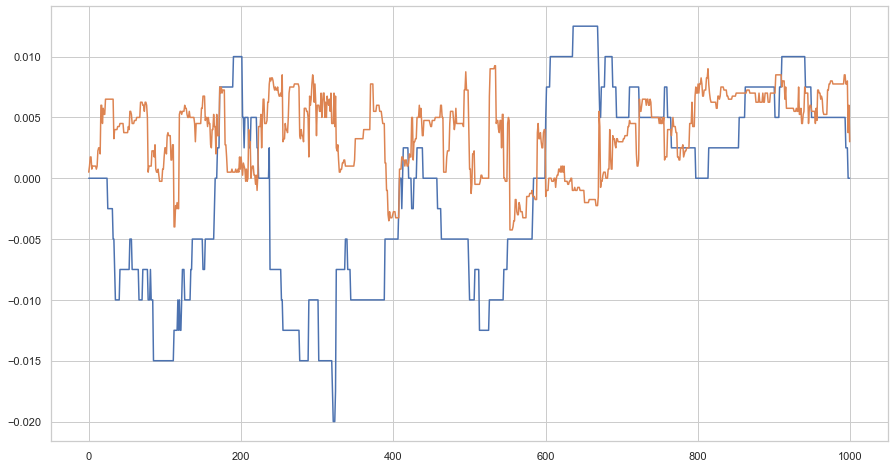

In [164]:
plt.subplots(figsize=(15,8))
plt.plot((y_valid/100)[:1000])
plt.plot((predictions/100)[:1000])

In [ ]:
# out-of-sample
rf.score(x_valid, y_valid)

In [ ]:
# out-of-sample
rf.score(x_valid, y_valid)

In [ ]:
dump(importances, 'importances.joblib')

In [ ]:
importances = load('importances.joblib')

In [ ]:
# save model
from joblib import dump, load
dump(rf, 'model.joblib')

In [ ]:
# load model
rf2 = load('model.joblib')
rf2.score(x_valid, y_valid)